In [1]:
using DrWatson

@quickactivate "Fission-Yeast-Rec8"
 
projectname()

"FissionYeast"

In [2]:
using Distributions
using Dates
using CairoMakie
using Random
using Distributed
using Optimization
using OptimizationOptimJL
using LinearAlgebra
using DataFrames
using XLSX
using Statistics
using Base.Iterators
using LogExpFunctions
using KernelDensity
using HighestDensityRegions
using LogDensityProblems
using ForwardDiff
using AdaptiveMCMC
using TransformVariables, TransformedLogDensities, LogDensityProblems, LogDensityProblemsAD,
    DynamicHMC, DynamicHMC.Diagnostics

import ForwardDiff: hessian
using MultivariateStats
    
include(srcdir("FissionYeast.jl"))

q (generic function with 1 method)

In [3]:
save_figs = false
run_inference = false

false

In [4]:
PIntData = XLSX.readxlsx(datadir() * "/exp_raw/S2B_Rec8_fluorescence_P&M-gametes_WT_DataInput.xlsx")["P-gamete-input"] 

PIntData = XLSX.eachtablerow(PIntData) |> DataFrames.DataFrame

MIntData = XLSX.readxlsx(datadir() * "/exp_raw/S2B_Rec8_fluorescence_P&M-gametes_WT_DataInput.xlsx")["M-gamete-input"] 

MIntData = XLSX.eachtablerow(MIntData) |> DataFrames.DataFrame

# keep_id = [ !any(ismissing.(v)) for v in eachcol(MIntData)] .|| [!any(ismissing.(v)) for v in eachcol(PIntData)] 

MIntData = MIntData[1:end,:]
PIntData = PIntData[1:end,:]


Row,Timepoint,Mating pair #1,Mating pair #2,Mating pair #3,Mating pair #4,Mating pair #5,Mating pair #6,Mating pair #7,Mating pair #8,Mating pair #9,Mating pair #10,Mating pair #11,Mating pair #12,Mating pair #13,Mating pair #14,Mating pair #15,Mating pair #16,Mating pair #17,Mating pair #18,Mating pair #19,Mating pair #20,Mating pair #21,Mating pair #22,Mating pair #23,Mating pair #24,Mating pair #25,Mating pair #26,Mating pair #27,Mating pair #28,Mating pair #29,Mating pair #30,Mating pair #31,Mating pair #32,Mating pair #33,Mating pair #34,Mating pair #35,Mating pair #36,Mating pair #37,Mating pair #38,Mating pair #39,Mating pair #40,Mating pair #41,Mating pair #42,Mating pair #43,Mating pair #44,Mating pair #45,Mating pair #46,Mating pair #47,Mating pair #48,Mating pair #49,Mating pair #50,Mating pair #51,Mating pair #52,Mating pair #53,Mating pair #54,Mating pair #55,Mating pair #56,Mating pair #57,Mating pair #58,Mating pair #59
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,-60.0,1.97767,3.80127,5.0256,2.53929,9.50224,15.672,0.587754,4.49361,5.30247,0.0,6.21748,1.49313,3.1884,7.10225,6.07341,8.9974,1.3662,16.2672,0.0,2.49975,8.56964,4.67876,0.0,6.41789,5.1799,0.0,3.60968,5.37211,0.674207,0.967239,6.54647,3.19834,2.30685,3.72692,0.506717,3.57719,7.99501,13.6719,5.74033,0.00919183,0.0,17.2094,2.74742,3.92799,0.0,0.0,3.92231,0.122031,1.9331,0.0,4.01782,23.8542,13.2443,0.0,9.17234,8.99092,1.6708,23.4475,11.0241
2,-50.0,6.45537,2.31853,0.0,2.49744,22.3001,25.4108,0.0,5.9125,10.1627,1.5119,13.9304,3.26363,0.701959,6.15191,5.17626,17.167,1.18834,25.0728,5.78158,0.500058,18.7574,11.4828,9.0951,0.0,9.65429,5.73997,2.23933,16.309,0.400768,2.32361,11.0373,0.0,3.05698,7.26261,1.00654,8.02659,15.6946,10.2758,0.0,1.40255,3.90578,28.7226,1.40727,5.45944,0.701387,4.31473,6.98023,0.0,4.97047,0.735631,7.45205,30.6207,29.0567,3.86926,12.7173,17.6286,3.99194,29.1704,14.055
3,-40.0,4.77989,9.00066,3.71128,4.55438,44.1235,42.1062,1.38915,9.92188,14.1771,6.78296,12.4933,0.0,4.6781,8.09209,8.43058,19.4642,2.94789,28.2918,18.4341,0.0,33.4489,17.985,30.7513,6.19794,21.8253,7.54205,0.0,33.5827,0.0,0.0,7.54392,8.15614,4.87492,8.60287,3.82073,6.8253,41.6665,9.89041,7.9601,3.65891,4.62547,39.1459,0.0,7.82593,1.97524,6.87718,2.33031,2.50636,23.485,1.15817,8.10603,34.3957,47.4181,14.7146,20.1936,28.4068,11.6869,32.9845,12.1906
4,-30.0,15.3792,25.34,10.6012,19.0938,63.7348,54.587,5.47648,15.9548,13.2337,14.0274,17.286,8.84065,4.36721,10.0782,6.50615,23.347,14.6357,31.0311,40.7501,3.73313,51.8584,29.5044,50.9751,4.33445,33.9141,6.55918,2.35016,40.9192,11.6203,7.71472,18.7836,12.6928,9.89779,15.0402,6.38565,13.7458,83.8978,30.7544,29.0068,14.4302,6.37709,77.6233,0.995752,11.9639,7.9432,13.8258,11.7541,10.2454,48.5578,9.258,10.3784,48.4937,60.8205,22.5114,37.0211,56.2272,17.1414,34.0764,13.6879
5,-20.0,31.718,42.5648,33.3715,39.0305,91.2047,79.9429,22.7787,28.5272,22.8928,27.2654,18.3452,16.5187,6.65067,25.4188,12.6705,38.9056,33.7287,38.0138,57.6347,22.7996,66.9676,38.2998,77.1177,12.7413,47.5321,16.433,8.82303,50.8149,36.7802,19.143,38.14,18.3866,33.0562,29.2501,14.8053,18.4757,106.838,62.235,55.1616,36.1241,6.00397,107.398,8.91802,23.4389,30.0384,31.6905,25.1173,26.4321,65.0986,19.7526,32.7573,76.6624,85.9869,36.4739,53.9648,86.7136,20.4191,50.7959,19.4867
6,-10.0,51.3616,57.7671,74.4115,51.7203,116.678,116.069,39.1235,42.1272,40.1366,48.6688,21.9219,38.4331,18.2187,51.1479,34.5359,59.1555,48.3522,53.8197,88.8281,36.1674,86.6323,55.2355,85.2739,32.4085,62.2291,31.056,31.0592,67.907,55.3117,46.3339,64.968,39.7129,62.831,51.6298,39.6795,21.9523,163.013,94.1358,68.1708,64.2456,37.1941,125.318,22.2566,36.6894,43.1949,56.9083,52.8,58.2979,75.5625,35.5885,50.6181,90.3281,106.172,64.4405,63.7424,120.459,39.7487,69.5329,34.0316
7,0.0,80.5098,84.3411,102.702,78.2551,15

In [5]:
# baseline_int = [minimum(vcat(m,p)) for (m,p) in zip(eachcol(MIntData[:,2:end]),eachcol(PIntData[:,2:end]))]

# MIntData[:,2:end] = mapslices(v-> v .- baseline_int,Array(MIntData[:,2:end]),dims = 2)
# PIntData[:,2:end] = mapslices(v-> v .- baseline_int,Array(PIntData[:,2:end]),dims = 2);

In [6]:
rprod(t,p) = t <= p[:t0] ? p[:bl] : p[:ν]*(t-p[:t0]) + p[:bl]

rprod (generic function with 1 method)

In [7]:
const t_data = PIntData[:,1]

error_rfit(u,p) = sum(([rprod(t,(t0=u[1],bl=u[2],ν=u[3])) for t in t_data] .- p).^2)

error_rfit_optf = OptimizationFunction(error_rfit, Optimization.AutoForwardDiff())

function get_r_dyn_bfgs(RData)

    u0 = [-61,1.,1.]

    p0 = Float64.(RData)

    prob_1d = OptimizationProblem(error_rfit_optf, u0, p0,lb = [-70,0.,0.],ub = [0.,10.,5.])

    sol_1d = solve(prob_1d,IPNewton())

    return sol_1d.u
end

sol_1d = get_r_dyn_bfgs(PIntData[:,3])

3-element Vector{Float64}:
 -42.25072882787268
   3.059902496938216
   1.8310788639490063

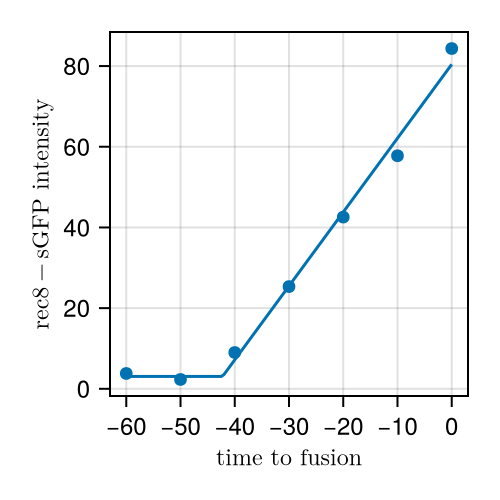

In [8]:
fig = Figure(size = (250,250), fontsize = 12.)

ax = Axis(fig[1,1],xlabel = L"\text{time to fusion}",ylabel = L"\text{rec8-sGFP intensity}")

# trange = 0:0.01:1.
trange = -60:0.5:0.

CairoMakie.lines!(ax,trange,[rprod(t,(t0=sol_1d[1],bl=sol_1d[2],ν=sol_1d[3])) for t in trange ])
CairoMakie.scatter!(ax,Float64.(PIntData[:,1]),Float64.(PIntData[:,3]))

if save_figs
    save(plotsdir("InferenceFinal/S2B/Example_fit_1P.pdf"),fig)
end

fig

In [9]:
PDyn = [get_r_dyn_bfgs(v) for v in eachcol(PIntData[:,2:end])]
MDyn = [get_r_dyn_bfgs(v) for v in eachcol(MIntData[:,2:end])];

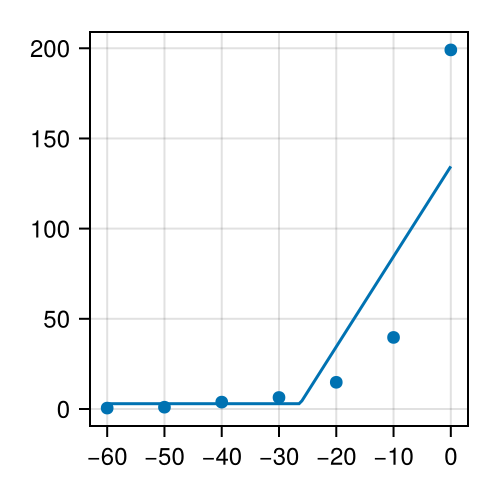

In [10]:
fig = Figure(size = (250,250), fontsize = 12.)

ax = Axis(fig[1,1])

PDyn_pred = [[rprod(t,(t0=posterior_t0,bl=posterior_bl,ν=posterior_ν)) for t in t_data] for (posterior_t0,posterior_bl,posterior_ν) in PDyn];
MDyn_pred = [[rprod(t,(t0=posterior_t0,bl=posterior_bl,ν=posterior_ν)) for t in t_data] for (posterior_t0,posterior_bl,posterior_ν) in MDyn];

PDyn_MSE = [sum((v.- y).^2) for (v,y) in zip(PDyn_pred,eachcol(PIntData[:,2:end]))]
MDyn_MSE = [sum((v.- y).^2) for (v,y) in zip(MDyn_pred,eachcol(MIntData[:,2:end]))];

PDyn_R2 = [1 - (sum((v.- y).^2) / sum((y.- mean(y)).^2)) for (v,y) in zip(PDyn_pred,eachcol(PIntData[:,2:end]))]
MDyn_R2 = [1 - (sum((v.- y).^2) / sum((y.- mean(y)).^2)) for (v,y) in zip(MDyn_pred,eachcol(MIntData[:,2:end]))];

n = 35
# n = argmax(PDyn_MSE)

sol_1d = PDyn[n] # lets look at worst fit to sense check

trange = -60:0.5:0.

CairoMakie.lines!(ax,trange,[rprod(t,(t0=sol_1d[1],bl=sol_1d[2],ν=sol_1d[3])) for t in trange ])
CairoMakie.scatter!(ax,Float64.(PIntData[:,1]),Float64.(PIntData[:,n+1]))

fig

In [11]:
mean(MDyn_R2)

0.9487643064383136

In [12]:
mean(PDyn_R2)

0.9205949508305549

In [13]:
PLinearTimes = map(x->x[1],PDyn)
MLinearTimes = map(x->x[1],MDyn)

PLinearStartID = minimum.([findall(t->t>=t_linear,t_data) for t_linear in PLinearTimes])
MLinearStartID = minimum.([findall(t->t>=t_linear,t_data) for t_linear in MLinearTimes]); 

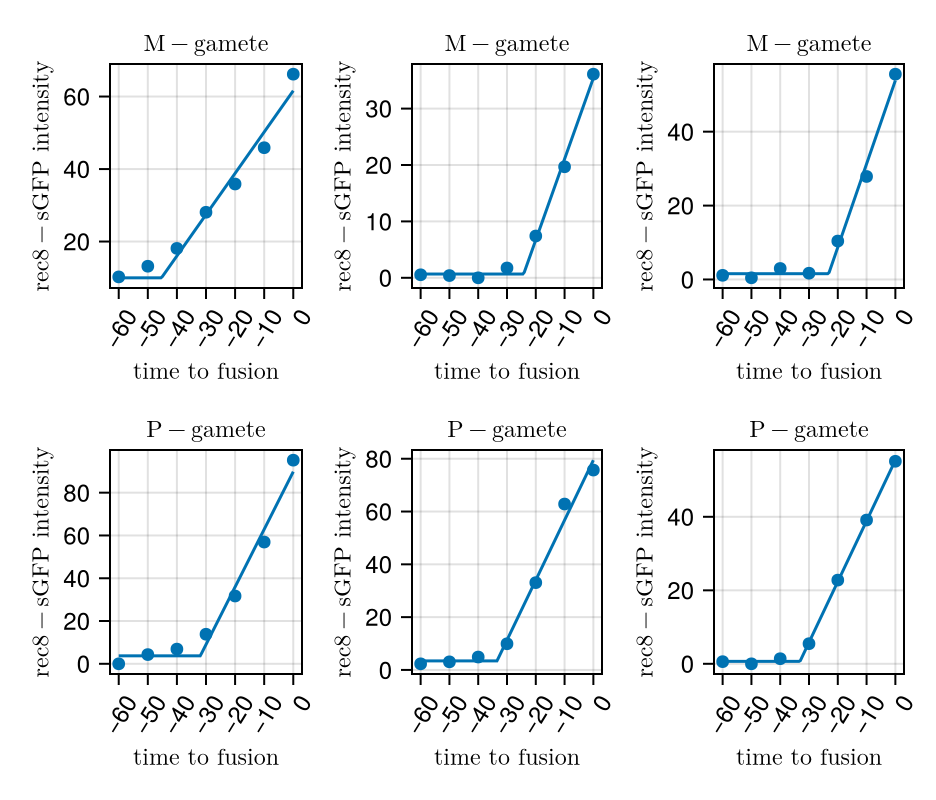

In [14]:
fig = Figure(size = (468,400), fontsize = 12.)

trange = -60:0.5:0.

for (n,j) in enumerate(rand(1:50,3))

    axM = Axis(fig[1,n],xlabel = L"\text{time to fusion}",ylabel = L"\text{rec8-sGFP intensity}",title = L"\text{M-gamete}")
    axP = Axis(fig[2,n],xlabel = L"\text{time to fusion}",ylabel = L"\text{rec8-sGFP intensity}",title = L"\text{P-gamete}")

    sol_1d = MDyn[j]

    CairoMakie.lines!(axM,trange,[rprod(t,(t0=sol_1d[1],bl=sol_1d[2],ν=sol_1d[3])) for t in trange ])
    CairoMakie.scatter!(axM,Float64.(PIntData[:,1]),Float64.(MIntData[:,j+1]))

    sol_1d = PDyn[j]

    CairoMakie.lines!(axP,trange,[rprod(t,(t0=sol_1d[1],bl=sol_1d[2],ν=sol_1d[3])) for t in trange ])
    CairoMakie.scatter!(axP,Float64.(PIntData[:,1]),Float64.(PIntData[:,j+1]))

    axM.xticklabelrotation = 45.
    axP.xticklabelrotation = 45.
end

colgap!(fig.layout,Relative(0.05))

if save_figs
    save(plotsdir("InferenceFinal/S2B/4_Example_fits.pdf"),fig)
end

fig

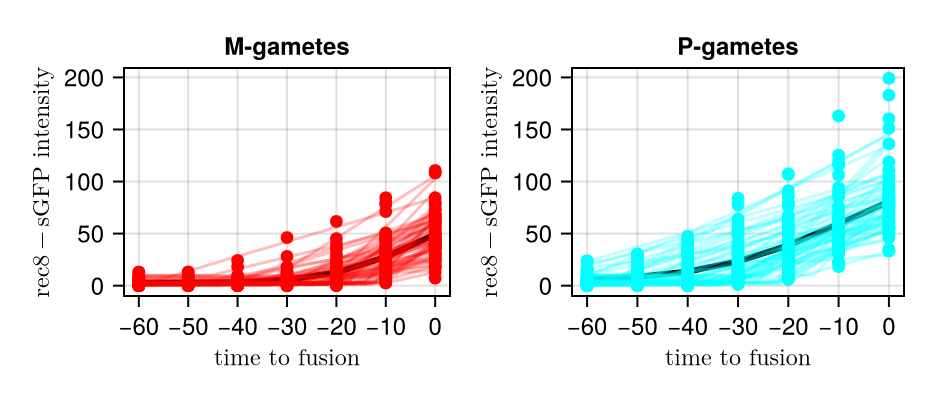

In [15]:
fig = Figure(size = (468,200), fontsize = 12.)

trange = -60:0.5:0.
tdata = Int.(PIntData[:,1]);

axM = Axis(fig[1,1],xlabel = L"\text{time to fusion}",ylabel = L"\text{rec8-sGFP intensity}",title = "M-gametes")
axP = Axis(fig[1,2],xlabel = L"\text{time to fusion}",ylabel = L"\text{rec8-sGFP intensity}",title = "P-gametes")

P_av = [mean([ i for i in PIntData[k,2:end]]) for k in 1:size(PIntData[:,1] ,1)]
M_av = [mean([ i for i in MIntData[k,2:end]]) for k in 1:size(MIntData[:,1] ,1)];

P_med = [median([ i for i in PIntData[k,2:end]]) for k in 1:size(PIntData[:,1] ,1)]
M_med = [median([ i for i in MIntData[k,2:end]]) for k in 1:size(MIntData[:,1] ,1)];

lines!(axM,tdata,M_av,color = :black,linewidth = 3.)
lines!(axP,tdata,P_av,color = :black,linewidth = 3.)

# lines!(axM,tdata,M_med,color = :green)
# lines!(axP,tdata,P_med,color = :green)

for j in 1:length(PDyn)

    sol_1d = MDyn[j]

    CairoMakie.lines!(axM,trange,[rprod(t,(t0=sol_1d[1],bl=sol_1d[2],ν=sol_1d[3])) for t in trange ],color = (:red,0.25))
    CairoMakie.scatter!(axM,Float64.(PIntData[:,1]),Float64.(MIntData[:,j+1]),color = :red)

    sol_1d = PDyn[j]

    CairoMakie.lines!(axP,trange,[rprod(t,(t0=sol_1d[1],bl=sol_1d[2],ν=sol_1d[3])) for t in trange ],color = (:cyan,0.25))
    CairoMakie.scatter!(axP,Float64.(PIntData[:,1]),Float64.(PIntData[:,j+1]),color = :cyan)
end

linkyaxes!(axM,axP)

if save_figs
    save(plotsdir("InferenceFinal/S2B/rec8_linear_to_curve.pdf"),fig)
end

fig

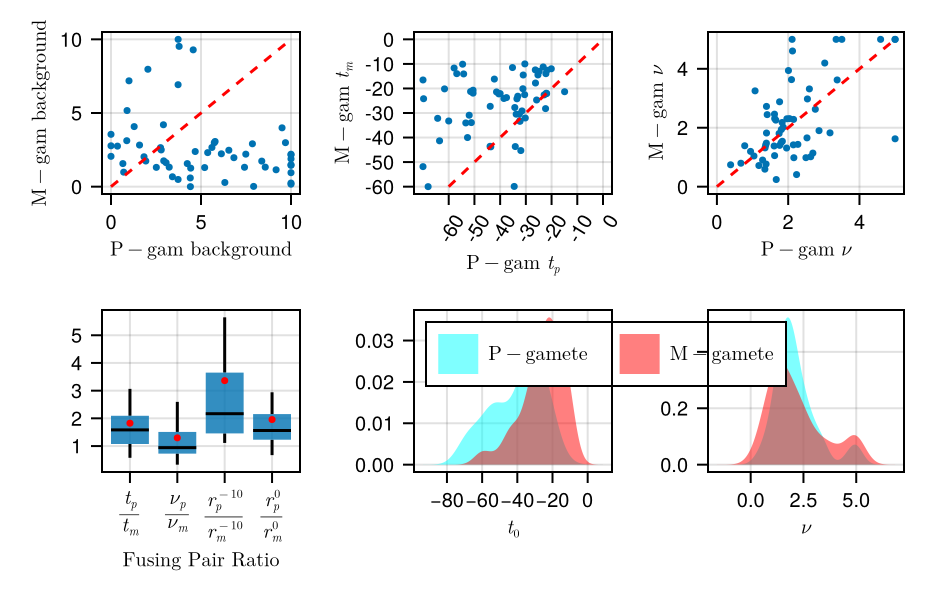

In [16]:
fig = Figure(size = (468,300), fontsize = 10.)

ms = 5. 

ax1 = Axis(fig[1,1],xlabel = L"\text{P-gam background} ",ylabel = L"\text{M-gam background}")
ax2 = Axis(fig[1,2],xlabel = L"\text{P-gam } t_p ",ylabel = L"\text{M-gam } t_m")
ax3 = Axis(fig[1,3],xlabel = L"\text{P-gam } \nu",ylabel = L"\text{M-gam } \nu")

CairoMakie.scatter!(ax1,[v[2] for v in PDyn],[v[2] for v in MDyn],markersize = ms)
CairoMakie.scatter!(ax2,[v[1] for v in PDyn],[v[1] for v in MDyn],markersize = ms)
CairoMakie.scatter!(ax3,[v[3] for v in PDyn],[v[3] for v in MDyn],markersize = ms)

CairoMakie.lines!(ax2,trange,trange,color = :red,linestyle = :dash)
CairoMakie.lines!(ax1,0:10,0:10,color = :red,linestyle = :dash)
CairoMakie.lines!(ax3,0:5,0:5,color = :red,linestyle = :dash)

ax3 = Axis(fig[2,1],xlabel = L"\text{Fusing Pair Ratio}",xticks =  (1:4,[L"\frac{t_p}{t_m}",L"\frac{\nu_p}{\nu_m}",L"\frac{r^{-10}_p}{r^{-10}_m}",L"\frac{r^{0}_p}{r^{0}_m}"]))
ax4 = Axis(fig[2,2],xlabel = L"t_0")
ax5 = Axis(fig[2,3],xlabel = L"\nu")

ratio_t = [-p[1]/-m[1] for (p,m) in zip(PDyn,MDyn)]
ratio_nu = [p[3]/m[3] for (p,m) in zip(PDyn,MDyn)]
# ratio_nu_t = [((-10-m[1])*m[3])/((-10-p[1])*p[3]) for (p,m) in zip(PDyn,MDyn)]

ratio_nu_t_10 = Array(PIntData[end-1,2:end]) ./  Array(MIntData[end-1,2:end])
ratio_nu_t_0 = Array(PIntData[end,2:end]) ./  Array(MIntData[end,2:end])

# ratio_nu_t_10 =  [((-10-m[1])*m[3])/((-10-p[1])*p[3]) for (p,m) in zip(PDyn,MDyn)]
# ratio_nu_t_0 =  [((0-m[1])*m[3])/((0-p[1])*p[3]) for (p,m) in zip(PDyn,MDyn)]

CairoMakie.boxplot!(ax3,vcat([1 for i in ratio_t],[2 for i in ratio_nu],[3 for i in ratio_nu_t_10 ],[4 for i in ratio_nu_t_0 ]),vcat(vcat(vcat(ratio_t,ratio_nu),ratio_nu_t_10),ratio_nu_t_0),show_outliers = false)

scatter!(ax3,[1,2,3,4],[mean(ratio_t),mean(ratio_nu),mean(ratio_nu_t_10),mean(ratio_nu_t_0)],color = :red,markersize = ms)

CairoMakie.density!(ax4,[v[1] for v in PDyn],color = (:cyan,0.5),label = L"\text{P-gamete}")
CairoMakie.density!(ax4,[v[1] for v in MDyn],color = (:red,0.5),label = L"\text{M-gamete}")

CairoMakie.density!(ax5,[v[3] for v in PDyn],color = (:cyan,0.5),label = L"\text{P-gamete}")
CairoMakie.density!(ax5,[v[3] for v in MDyn],color = (:red,0.5),label = L"\text{M-gamete}")

ax2.xticks = (MIntData[:,1],string.([-60,-50,-40,-30,-20,-10,0]))
ax2.yticks = (MIntData[:,1],string.([-60,-50,-40,-30,-20,-10,0]))

axislegend(ax4,position = :lt, orientation = :horizontal)

ax2.xticklabelrotation = 45.

if save_figs
    save(plotsdir("InferenceFinal/S2B/rec8_dyn_characteristics.pdf"),fig)
end

fig

In [17]:
using HypothesisTests

In [18]:
ApproximateTwoSampleKSTest(Float64.(Array(PIntData[end-1,2:end])),Float64.(Array(MIntData[end-1,2:end])))

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.610169

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-09

Details:
    number of observations:   [59,59]
    KS-statistic:              3.3140686244339634


In [19]:
M_nu =  [m[3] for m in MDyn]
P_nu = [p[3] for p in PDyn];

In [20]:
ApproximateTwoSampleKSTest(Float64.(Array(PIntData[end-1,2:end])),Float64.(Array(MIntData[end-1,2:end])))

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.610169

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-09

Details:
    number of observations:   [59,59]
    KS-statistic:              3.3140686244339634


In [21]:
ApproximateTwoSampleKSTest(Float64.(M_nu),Float64.(Array(P_nu)))

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.169492

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.3650

Details:
    number of observations:   [59,59]
    KS-statistic:              0.9205746178983235


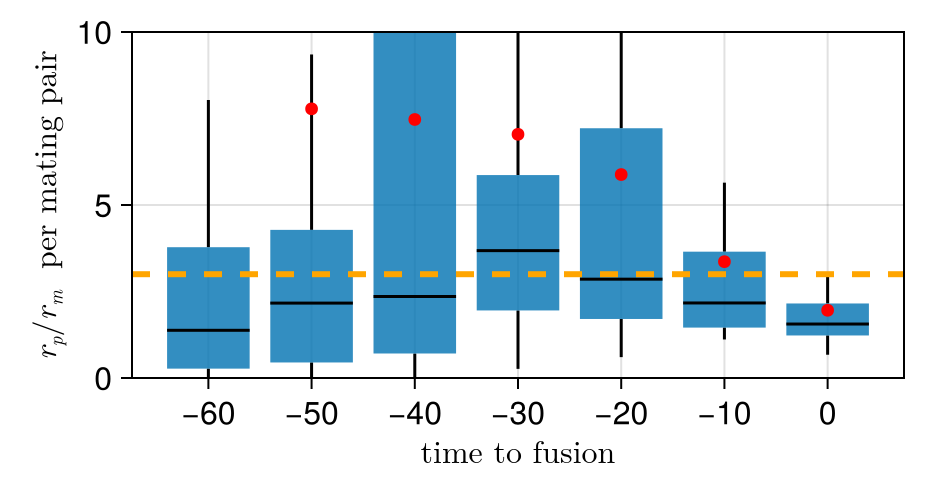

In [22]:
all_ratios = [filter(x->!(x==Inf),Array(PIntData[k,2:end]) ./  Array(MIntData[k,2:end])) for k in 1:size(PIntData,1)]

all_times = reduce(vcat,[[k for _ in 1:length(r)] for (k,r) in zip(tdata,all_ratios)]);

mean_ratios = [mean(v) for v in all_ratios]

fig = Figure(size = (468,250), fontsize = 16.)

ax = Axis(fig[1,1],xlabel = L"\text{time to fusion}",ylabel = L"r_p / r_m \text{  per mating pair}")

boxplot!(ax,all_times,reduce(vcat,all_ratios),show_outliers = false,width = 10.)

scatter!(ax,tdata,mean_ratios,color = :red)

hlines!(3.,color  = :orange, linestyle = :dash, linewidth = 3.)
ylims!(ax,0.,10.)

if save_figs
    save(plotsdir("InferenceFinal/S2B/ratios_at_times.pdf"),fig)
end

fig

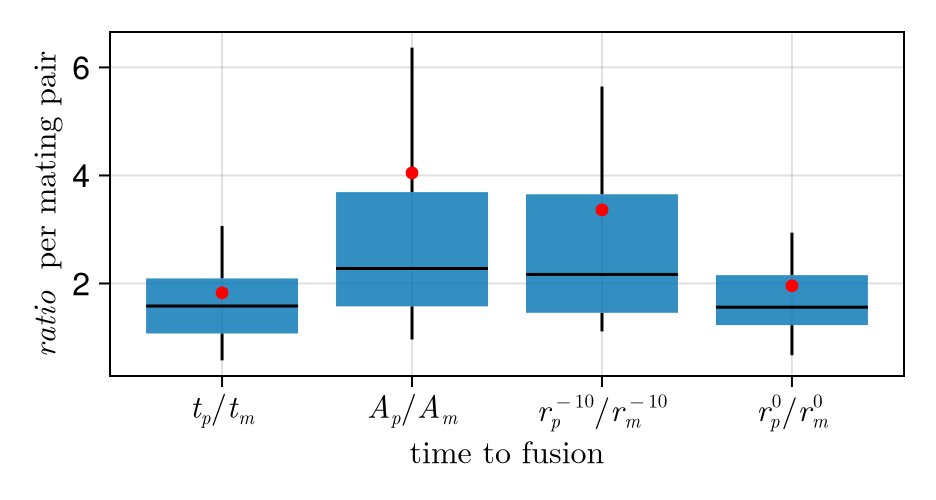

In [23]:
PDyn_Area = [(0 - p[1])^2*p[3]/2 for p in PDyn]
MDyn_Area = [(0 - p[1])^2*p[3]/2 for p in MDyn]

Area_ratio = PDyn_Area ./ MDyn_Area 

fig = Figure(size = (468,250), fontsize = 16.)

ax = Axis(fig[1,1],xlabel = L"\text{time to fusion}",ylabel = L"ratio \text{  per mating pair}")

CairoMakie.boxplot!(ax,vcat([1 for i in ratio_t],[2 for i in Area_ratio],[3 for i in ratio_nu_t_10 ],[4 for i in ratio_nu_t_0 ]),vcat(vcat(vcat(ratio_t,Area_ratio),ratio_nu_t_10),ratio_nu_t_0),show_outliers = false)
scatter!(ax,[1,2,3,4],[mean(ratio_t),mean(Area_ratio),mean(ratio_nu_t_10),mean(ratio_nu_t_0)],color = :red)

ax.xticks = (1:4,[L"t_p/t_m",L"A_p/A_m",L"r^{-10}_p/r^{-10}_m",L"r^{0}_p/r^{0}_m"])

if save_figs    
    save(plotsdir("InferenceFinal/S2B/summary_ratios.pdf"),fig)
end

fig

In [24]:
k = mean(Array(PIntData[end-1,2:end]) ./  Array(MIntData[end-1,2:end])) # average difference at t = -10

print("Average ratio at t = -10 :"  * string(k))

Average ratio at t = -10 :3.3620544619811565

In [25]:
AllFData = XLSX.readxlsx(datadir() * "/exp_raw/S2B_Rec8_fluorescence_P&M-gametes_WT_DataInput.xlsx")["All"] 

AllFData = XLSX.eachtablerow(AllFData) |> DataFrames.DataFrame;

In [26]:
allPF = Float64.(AllFData[:,3])
allMF = Float64.(AllFData[:,4]);
allF = Float64.(hcat(allMF,allPF)) |> transpose |> collect

2×354 Matrix{Float64}:
 0.0      0.869016  6.72349  0.00840658  …  16.9296  43.9179   9.63265
 1.97767  3.80127   5.0256   2.53929        39.7487  69.5329  34.0316

In [27]:
M = fit(PCA,allF; maxoutdim=1,mean = 0)

Mproj = projection(M)

βm_all = Mproj[1,1];
βp_all = Mproj[2,1]

β_all = βm_all  / βp_all

0.3701977733357209

In [28]:
βp_all /  βm_all

2.7012588190073497

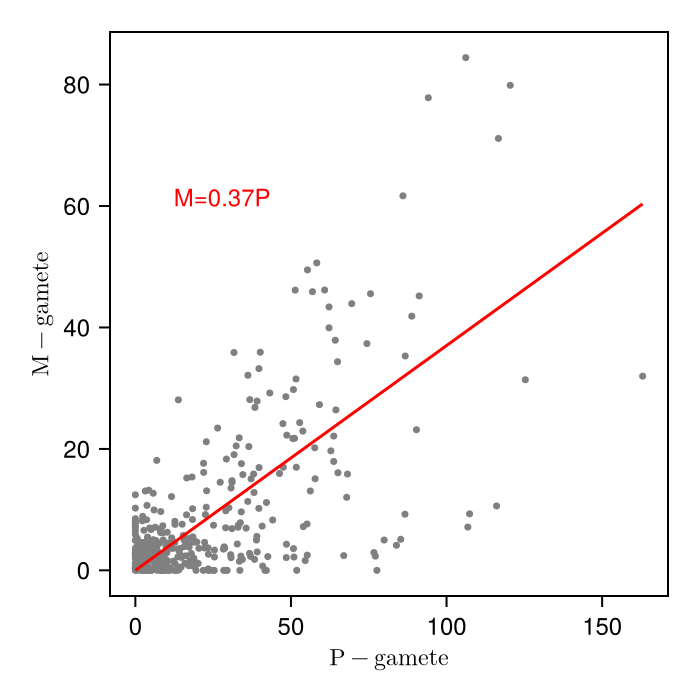

In [29]:
fig = Figure(size = (350,350), fontsize = 12.)

ax = Axis(fig[1,1],xlabel = L"\text{P-gamete}",ylabel = L"\text{M-gamete}",xgridvisible = false,ygridvisible = false)

scatter!(ax,allPF,allMF,markersize = 5.,color = :grey)

# scatter!(ax,allMF,allPF, color = (:blue, 0.5))

lines!(ax,allPF,allPF*β_all,color = :red)

yloc = 0.7*maximum(allMF)
xloc = 0.5*mean(allPF)

text!(ax,xloc,yloc, text = "M=" * string(round(β_all,digits = 2)) * "P", color = :red)

if save_figs
    save(plotsdir("InferenceFinal/S2B/AllData_Orthog_Fit_"  * string(now()) * ".pdf"),fig)
end


fig

In [30]:
v = allPF*β_all
y = allMF
1 - (sum((v.- y).^2) / sum((y .- mean(y)).^2))

0.41714767013902787

In [31]:
all_ratio = []

t_string = unique(AllFData[:,1])

for t in t_string
    allPF = Float64.(AllFData[AllFData[:,1] .== t,3])
    allMF = Float64.(AllFData[AllFData[:,1] .== t,4])
    allF = Float64.(hcat(allMF,allPF)) |> transpose |> collect

    M = fit(PCA,allF; maxoutdim=1,mean = 0)

    Mproj = projection(M)

    βm = Mproj[1,1];
    βp = Mproj[2,1]

    push!(all_ratio,βp / βm)
end

push!(all_ratio, βp_all / βm_all)

push!(t_string, "All")

7-element Vector{Any}:
 "-60 min"
 "-50 min"
 "-40 min"
 "-30 min"
 "-20 min"
 "-10 min"
 "All"

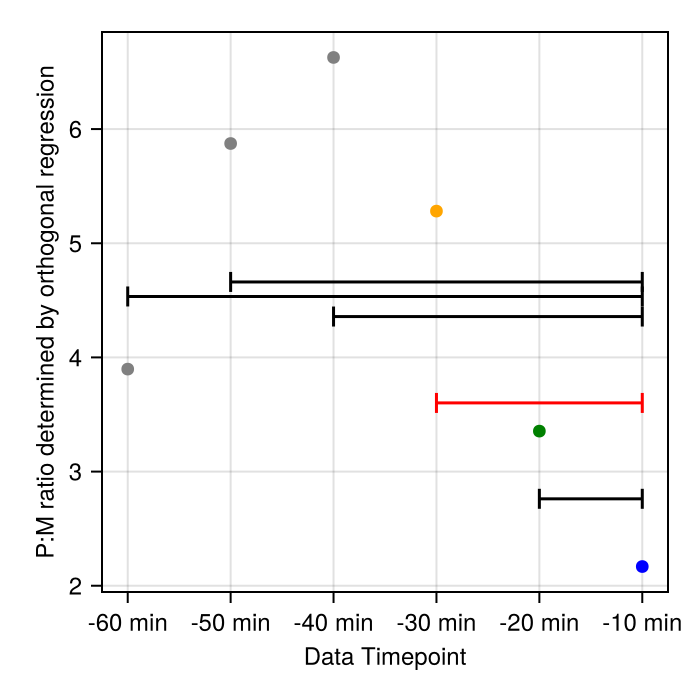

In [32]:
fig = Figure(size = (350,350), fontsize = 12.)

ax = Axis(fig[1,1],xlabel = "Data Timepoint", ylabel = "P:M ratio determined by orthogonal regression")

scatter!(all_ratio[1:end-1],color = [:grey,:grey,:grey,:orange,:green,:blue])

lows = 1:5
highs = 6

rangebars!(ax,[mean(all_ratio[n:6]) for n in 1:5],lows,highs,direction = :x,whiskerwidth = 10,color = [n != 4 ? :black : :red for n in 1:5])

ax.xticks = (1:6,t_string[1:end-1])

fig

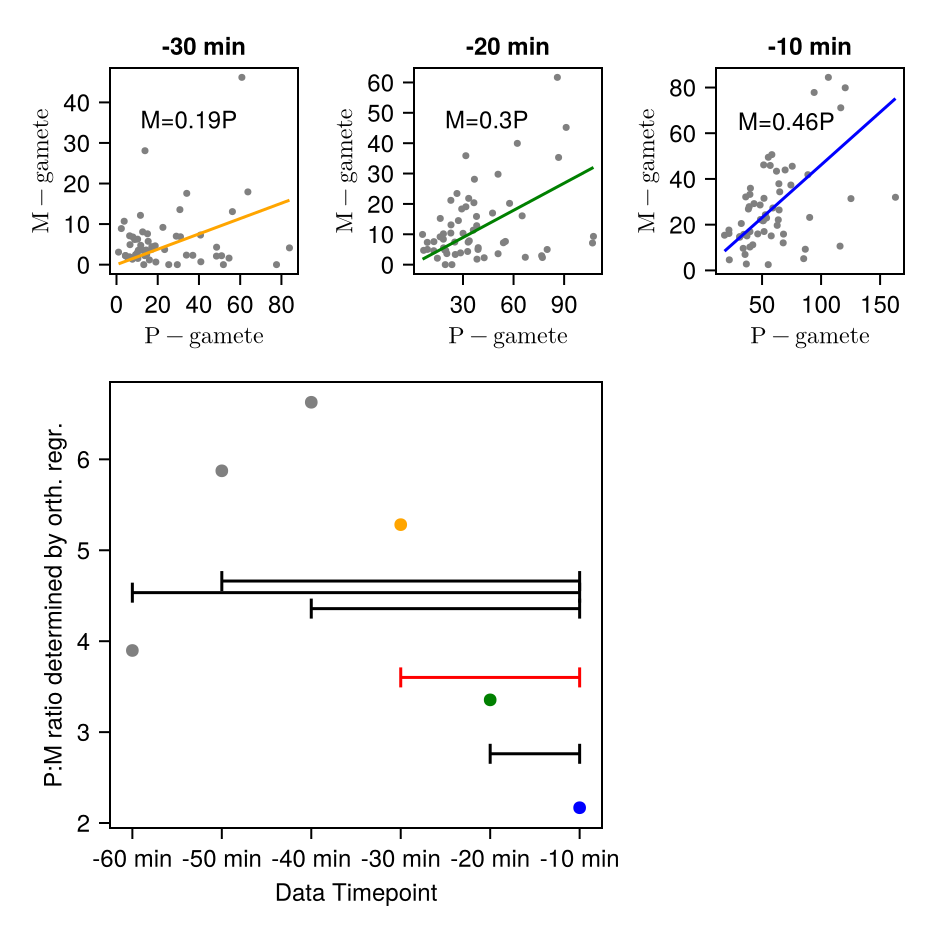

In [33]:
fig = Figure(size = (468,468), fontsize = 12.)

fit_c = [:orange,:green,:blue]

for (n,t) in enumerate(["-30 min", "-20 min","-10 min"])
    allPF = Float64.(AllFData[AllFData[:,1] .== t,3])
    allMF = Float64.(AllFData[AllFData[:,1] .== t,4])
    allF = Float64.(hcat(allMF,allPF)) |> transpose |> collect

    M = fit(PCA,allF; maxoutdim=1,mean = 0)

    Mproj = projection(M)

    βm = Mproj[1,1];
    βp = Mproj[2,1]

    β = βm / βp

    ax = Axis(fig[1,n],xlabel = L"\text{P-gamete}",ylabel = L"\text{M-gamete}",title = t,xgridvisible = false,ygridvisible = false)

    scatter!(ax,allPF,allMF,markersize = 5., color = :grey)

    yloc = 0.7*maximum(allMF)
    xloc = 0.5*mean(allPF)

    text!(ax,xloc,yloc, text = "M=" * string(round(β,digits = 2)) * "P")

    # scatter!(ax,allMF,allPF, color = (:blue, 0.5))

    lines!(ax,allPF,allPF*β,color = fit_c[n])

end

ax = Axis(fig[2:3,1:2],xlabel = "Data Timepoint", ylabel = "P:M ratio determined by orth. regr.",xgridvisible = false,ygridvisible = false)

scatter!(all_ratio[1:end-1],color = [:grey,:grey,:grey,:orange,:green,:blue])

lows = 1:5
highs = 6

rangebars!(ax,[mean(all_ratio[n:6]) for n in 1:5],lows,highs,direction = :x,whiskerwidth = 10,color = [n != 4 ? :black : :red for n in 1:5])

ax.xticks = (1:6,t_string[1:end-1])

if save_figs
    save(plotsdir("InferenceFinal/AllRatioSummary_"  * string(now()) * ".pdf"),fig)
end

fig


In [34]:
# p_t = [-p[1] for p in PDyn]
# m_t = [-p[1] for p in MDyn]

# νp = [p[3] for p in PDyn]
# νm = [p[3] for p in MDyn];

# t_mat = hcat(p_t,m_t) |> transpose |> collect
# ν_mat = hcat(νp,νm) |> transpose |> collect;

# d_mat = vcat(t_mat,ν_mat) 

# t_dist = fit(MvNormal,t_mat)
# ν_dist = fit(MvNormal,ν_mat)

# r_dist = fit(MvNormal,d_mat)

# randR(mutant) = sum(rand(t_dist).*rand(ν_dist).* [mutant[2],mutant[1]])

In [35]:
# kp = mean(Array(PIntData[end-1,2:end]) ./  Array(MIntData[end-1,2:end]))

# kp = βp_all / βm_all

kp = mean(all_ratio[4:6])


print("ratio used for Pm calibration: " * string(kp))

ratio used for Pm calibration: 3.60141956626879

In [36]:
PmData = XLSX.readxlsx(datadir() * "/exp_raw/PQ_DataInput.xlsx")["Pm_Input"] 

PmData = XLSX.eachtablerow(PmData) |> DataFrames.DataFrame

max_au_correspondence = 12. 

PMutants = [("M","P") for i in 1:9]
PCopies = [(0,0),(1,0),(2,0),(0,1),(1,1),(2,1),(0,2),(1,2),(2,2)]

PCopNames = [L"\text{h+/- Δrec8}",L"\text{h+ Δrec8 h- WT}",L"\text{h+ Δrec8 x h- rec8++}",L"\text{h+ WT x h- Δrec8}",
                L"\text{WT x WT}",L"\text{h+ WT x h- rec8++}",L"\text{h+ rec8++ x h- Δrec8}",L"\text{h+ rec8++ x h- WT}",L"\text{h+ rec8++ x h- rec8++}"]

n_au = size(PmData,1)

print("ratio used for calibration: " * string(kp))

PmData[!,:AU] = [ νm + νp*kp for (νm,νp) in PCopies]

PmData[!,"(M,P)"] = PCopies

PmData[!,:r] = PmData[!,:AU] 

select(PmData,"(M,P)","AU","r","N_spores","N_germinate","N_fail")

ratio used for calibration: 3.60141956626879

Row,"(M,P)",AU,r,N_spores,N_germinate,N_fail
,Tuple…,Float64,Float64,Any,Any,Any
1,"(0, 0)",0.0,0.0,41100,8970,32130
2,"(1, 0)",1.0,1.0,43225,22700,20525
3,"(2, 0)",2.0,2.0,18050,10760,7290
4,"(0, 1)",3.60142,3.60142,45175,35040,10135
5,"(1, 1)",4.60142,4.60142,48800,46060,2740
6,"(2, 1)",5.60142,5.60142,27550,26440,1110
7,"(0, 2)",7.20284,7.20284,13975,13370,605
8,"(1, 2)",8.20284,8.20284,13300,12750,550
9,"(2, 2)",9.20284,9.20284,16350,15510,840


In [37]:
# kq = mean(Array(PIntData[end-1,2:end]) ./  Array(MIntData[end-1,2:end]))
# kq = βp_all / βm_all

kq = mean(all_ratio[4:6])

print("ratio used for q calibration: " * string(kq))

ratio used for q calibration: 3.60141956626879

In [38]:
QData = XLSX.readxlsx(datadir() * "/exp_raw/PQ_DataInput.xlsx")["Qm_Input"] 

QData = XLSX.eachtablerow(QData) |> DataFrames.DataFrame

QMutants = ["M","M","M","P","P","P","P"]

QCopyNumber = [0,1,2,1,2,3,4]

QCopies = [(0,0),(1,0),(2,0),(0,1),(0,2),(0,3),(0,4)]

QData[!,"(M,P)"] = QCopies

QData[!,:AU] = [m =="P" ? ν*kq : ν for (m,ν) in zip(QMutants,QCopyNumber)]

print("ratio used for calibration: " * string(kq))

QData[!,:r] = QData[!,:AU]

select(QData,"(M,P)","AU","r","Abundance","N_survived","N_fail")

ratio used for calibration: 3.60141956626879

Row,"(M,P)",AU,r,Abundance,N_survived,N_fail
,Tuple…,Real,Real,Any,Any,Any
1,"(0, 0)",0,0,4090.8,3848,242.802
2,"(1, 0)",1,1,204.175,185,19.1751
3,"(2, 0)",2,2,256.668,205,51.6681
4,"(0, 1)",3.60142,3.60142,316.74,212,104.74
5,"(0, 2)",7.20284,7.20284,243.181,111,132.181
6,"(0, 3)",10.8043,10.8043,221.287,70,151.287
7,"(0, 4)",14.4057,14.4057,225.147,48,177.147


In [39]:
fData = XLSX.readxlsx(datadir() * "/exp_raw/PQ_DataInput.xlsx")["f_input"] 

fData = XLSX.eachtablerow(fData) |> DataFrames.DataFrame

Row,Not mating individuals,mating_pairs,not_mating_pairs,efficiency
,Any,Any,Any,Any
1,611,1245,305,0.803226
2,659,1259,329,0.792821
3,645,1233,322,0.792926


In [40]:
struct MateLogPosterior 
    PmData
    priors
end

priors_Pm = (hm=Uniform(1,10),am=Uniform(0,10),κm=Uniform(0,1),Δm = Uniform(0,1) )

# define a callable that unpacks parameters, and evaluates the log loglikelihood

function (problem::MateLogPosterior)(θ)

    @unpack hm, am, κm,Δm = θ
    @unpack PmData,priors = problem

    loglikelihood = sum(PmData[:,:N_germinate].*log.([Pm(r,(hm=hm,am=am,κm=κm,Δm=Δm)) for r in PmData[:,:r]]) .+ PmData[:,:N_fail].*log.([1 - Pm(r,(hm=hm,am=am,κm=κm,Δm=Δm)) for r in PmData[:,:r]]))

    logprior = log(pdf(priors[:hm],hm)) + log(pdf(priors[:am],am)) + log(pdf(priors[:κm],κm)) + log(pdf(priors[:Δm],Δm)) 

    loglikelihood + logprior
end

struct QLogPosterior 
    QData
    priors
end

priors_Q = (hq=Uniform(1,20),aq=Uniform(0,20),κq=Uniform(0,1),Δq = Uniform(0,1) )

# define a callable that unpacks parameters, and evaluates the log likelihood
function (problem::QLogPosterior)(θ)

    @unpack hq, aq, κq,Δq = θ
    @unpack QData,priors = problem

    loglikelihood = sum(QData[:,:N_survived].*log.([q(r,(hq=hq,aq=aq,κq=κq,Δq=Δq)) for r in QData[:,:r]]) .+ QData[:,:N_fail].*log.([1 - q(r,(hq=hq,aq=aq,κq=κq,Δq=Δq)) for r in QData[:,:r]]))
    
    logprior = log(pdf(priors[:hq],hq)) + log(pdf(priors[:aq],aq)) + log(pdf(priors[:κq],κq)) + log(pdf(priors[:Δq],Δq)) 

    loglikelihood + logprior
end

struct fLogPosterior 
    fData
    priors
end

priors_f = (f=Uniform(0,1),na = Uniform(0,1))

# define a callable that unpacks parameters, and evaluates the log likelihood
function (problem::fLogPosterior)(θ)

    @unpack f,na = θ
    @unpack fData,priors = problem

    loglikelihood = fData[1,:mating_pairs]*log(f) + fData[1,:not_mating_pairs]*log(1-f)
    logprior = log(pdf(priors[:f],f))
    loglikelihood + logprior
end

In [41]:
problem_m = MateLogPosterior(PmData,priors_Pm);

problem_m((hm = 1., am = 1., κm= 0.5,Δm=0.1))

-200000.00742864664

In [42]:
# sometimes you must try running a few times so the solver can find an initial stepsize 

if run_inference

    problem_m = MateLogPosterior(PmData,priors_Pm);
    problem_q = QLogPosterior(QData,priors_Q);
    problem_f = fLogPosterior(fData,priors_f);

    trans_m = as((hm = as(Real,1.,20.),am = asℝ₊,κm=as𝕀,Δm=as𝕀))
    trans_q = as((hq = as(Real,1.,20.),aq = asℝ₊,κq=as𝕀,Δq=as𝕀))
    trans_f = as((f=as𝕀,na =as𝕀))

    lm = TransformedLogDensity(trans_m, problem_m)
    lq = TransformedLogDensity(trans_q, problem_q)
    lf = TransformedLogDensity(trans_f, problem_f)

    ∇lm = ADgradient(:ForwardDiff, lm)
    ∇lq = ADgradient(:ForwardDiff, lq)
    ∇lf = ADgradient(:ForwardDiff, lf)

    out_m = mcmc_with_warmup(Random.default_rng(), ∇lm, 50000; reporter = NoProgressReport())
    out_q = mcmc_with_warmup(Random.default_rng(), ∇lq, 50000; reporter = NoProgressReport())
    out_f = mcmc_with_warmup(Random.default_rng(), ∇lf, 50000; reporter = NoProgressReport());
end

In [43]:
if run_inference

    Xtm = TransformVariables.transform.(trans_m, eachcol(out_m.posterior_matrix))
    Xtq = TransformVariables.transform.(trans_q, eachcol(out_q.posterior_matrix))
    Xtf = TransformVariables.transform.(trans_f, eachcol(out_f.posterior_matrix));

    posterior_hm = map(x->x[:hm],Xtm)
    posterior_am = map(x->x[:am],Xtm)
    posterior_κm = map(x->x[:κm],Xtm)
    posterior_Δm = map(x->x[:Δm],Xtm)

    posterior_hq = map(x->x[:hq],Xtq)
    posterior_aq = map(x->x[:aq],Xtq)
    posterior_κq = map(x->x[:κq],Xtq)
    posterior_Δq = map(x->x[:Δq],Xtq)

    posterior_f = map(x->x[:f],Xtf);

    all_posterior = [posterior_f,posterior_hm,posterior_am,posterior_κm,posterior_Δm,posterior_hq,posterior_aq,posterior_κq,posterior_Δq];
end

In [44]:
if run_inference

    mean_posterior = mean.(all_posterior);

    all_posterior_m = reduce(hcat,all_posterior);
    pp = (f=mean_posterior[1],hm=mean_posterior[2],am=mean_posterior[3],κm=mean_posterior[4],Δm=mean_posterior[5],hq=mean_posterior[6],aq=mean_posterior[7],κq=mean_posterior[8],Δq=mean_posterior[9])

    save(datadir("exp_pro/PQInference/posterior_hill_" * string(now()) * ".jld2"),Dict("all_posterior"=>all_posterior_m,"map"=>pp,"ratio"=>kp))
    save(datadir("exp_pro/PQInference/ExpDataFinal_" * string(now()) * ".jld2"),Dict("PmData"=>PmData,"QData"=>QData,"FData"=>fData,"ratio"=>kp))

else
    posterior_data = load(datadir("exp_pro/PQInference/posterior_hill_Final.jld2"))
    all_posterior_m = posterior_data["all_posterior"]
    pp = posterior_data["map"]
end

pp

(f = 0.8027641261375005, hm = 1.6951516820841541, am = 1.5544089543154018, κm = 0.7719829093343913, Δm = 0.9994617472328807, hq = 1.6155652110062733, aq = 6.105708950334785, κq = 0.8849584798764843, Δq = 0.40584439734370054)

In [45]:
fig = CairoMakie.Figure(size = (180,180),fontsize = 12.)

ax_m = Axis(fig[1,1],ylabel = L"\text{Probability}",xgridvisible = false,ygridvisible = false)
# ax_q = Axis(fig[2,1],ylabel = L"q",xgridvisible = false,ygridvisible = false)

max_au_correspondence = ceil(QData[end,:AU])

n=1

all_colors = [:black,:orange]

CairoMakie.lines!(ax_m,0.:0.01:max_au_correspondence,[Pm(r,pp) for r in 0.:0.01:max_au_correspondence], color = all_colors[1],label = L"P_m")
CairoMakie.scatter!(ax_m,PmData[!,:r],PmData[!,:N_germinate] ./ PmData[!,:N_spores],color = all_colors[1],marker = 'x')

CairoMakie.lines!(ax_m,0.:0.01:max_au_correspondence,[q(r,pp) for r in 0.:0.01:max_au_correspondence], color = all_colors[2],label = L"q")
CairoMakie.scatter!(ax_m,QData[!,:r],QData[!,:N_survived] ./ QData[!,:Abundance],color = all_colors[2],marker = 'x')

ylims!(ax_m,0.,1.1)
ylims!(ax_q,0.,1.1)

# ax_m.yticks = (0:0.2:1,string.(0:0.2:1))
# ax_q.yticks = (0:0.2:1,string.(0:0.2:1))

# ax_m.xticks = (0:1:max_au_correspondence,string.(Int.(0:1:max_au_correspondence)))
# ax_q.xticks = (0:1:max_au_correspondence,string.(Int.(0:1:max_au_correspondence)))

ax_m.xlabel = L" \text{rec 8 a.u.}"

axislegend(ax_m)

if save_figs
    save(plotsdir("InferenceFinal/Hill_BayesFits_"  * string(now()) * ".pdf"),fig)
end

fig

UndefVarError: UndefVarError: ax_q not defined

In [46]:
fits_df = DataFrames.DataFrame()

fits_df[!,:au] = 0.:0.01:max_au_correspondence
fits_df[!,:PmFit] = [Pm(r,pp) for r in 0.:0.01:max_au_correspondence]
fits_df[!,:QFit] = [q(r,pp) for r in 0.:0.01:max_au_correspondence]

# XLSX.writetable("notebook_data/PQFits" * string(now()) * ".xlsx","FitData" => fits_df, "Pm_ExperimentalData" => select(PmData, Not(["(M,P)"])), "Q_ExperimentalData" => select(QData, Not(["(M,P)"])))

1501-element Vector{Float64}:
 0.9316474362805157
 0.9316194869859231
 0.9315617963855077
 0.9314825729178506
 0.931385060970664
 0.931271225250023
 0.9311424370028717
 0.9309997307843448
 0.9308439271229089
 0.930675699981671
 ⋮
 0.21572326278385107
 0.21557528930639808
 0.2154275138136632
 0.215279935961791
 0.21513255540763193
 0.21498537180874028
 0.21483838482337264
 0.21469159411048655
 0.21454499932973903

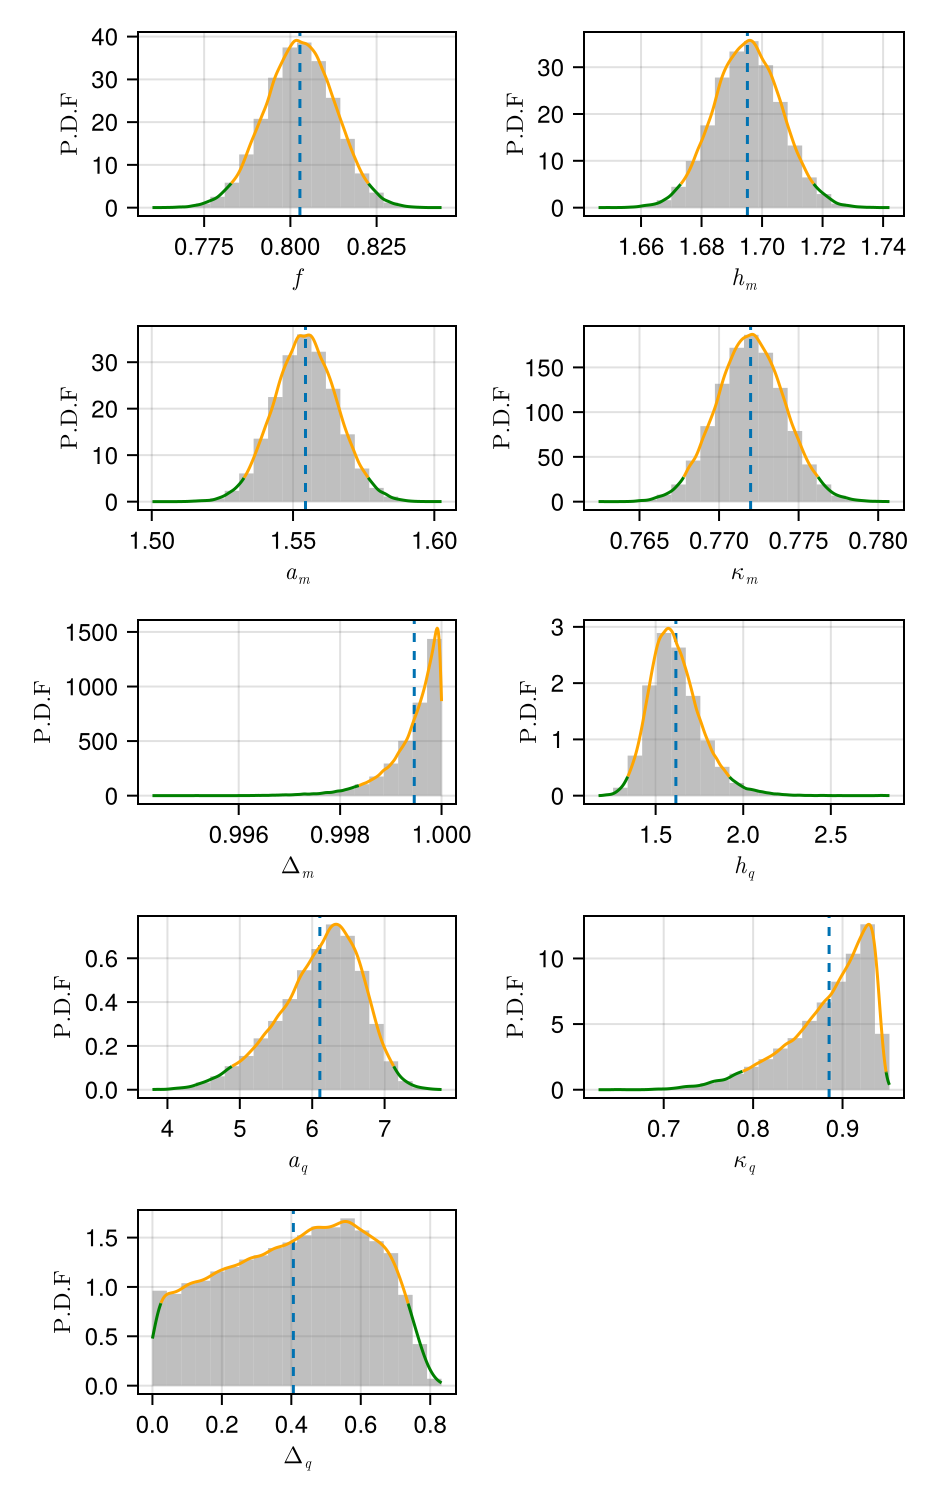

In [53]:
fig = Figure(size =  (468,750), fontsize = 12.)

ax_id = [(1,1),(1,2),(2,1),(2,2),(3,1),(3,2),(4,1),(4,2),(5,1)]

var_names = [L"f",L"h_m",L"a_m",L"\kappa_m",L"\Delta_m",L"h_q",L"a_q",L"\kappa_q",L"\Delta_q"]

prob_posterior = [1,4,5,8,9];
param_posterior = [2,3,6,7];

normalize_xaxis = false

all_ci = []

for (n,d) in enumerate(eachcol(all_posterior_m))
    ax = Axis(fig[ax_id[n]...], xlabel = var_names[n],ylabel = L"\text{P.D.F}")
    hist!(ax,d,color = (:grey,0.5),bins = 20,normalization = :pdf)

    vlines!(mean(d),linestyle = :dash)

    k = kde(d)
    xgrid = range(minimum(d); stop = maximum(d), length = 1000)
    ygrid = pdf.(Ref(k), xgrid)

    threshold = first(hdr_thresholds([0.95], ygrid))
    
    push!(all_ci,xgrid[findall(y -> y > threshold,ygrid)])

    lines!(ax,xgrid,ygrid,color = [y < threshold ? :green : :orange for y in ygrid])

    if normalize_xaxis
        if n in prob_posterior
            xlims!(ax,0.,1.)
            hlines!(ax,1.)
        else
            xlims!(ax,0.,10.)
            hlines!(ax,0.1)
        end
    end

end

if save_figs
    save(plotsdir("InferenceFinal/PHill_Posteriors_"  * string(now()) * ".pdf"),fig)
end

fig

In [54]:
[L"f",L"h_m",L"a_m",L"\kappa_m",L"\Delta_m(1-\kappa_m)",L"h_q",L"a_q",L"\kappa_q",L"\Delta_q(1-\kappa_q)"]

map(x->(x[1],x[end]),all_ci)

9-element Vector{Tuple{Float64, Float64}}:
 (0.7829188110833708, 0.8225981093935125)
 (1.6731936707933368, 1.7169811284701326)
 (1.5327116014429027, 1.576546203268349)
 (0.7677887129883556, 0.7762068406660418)
 (0.9983736100169216, 0.9999999839106573)
 (1.3420279164987075, 1.9204482510673984)
 (4.89247146155476, 7.123082754547801)
 (0.7883279112102098, 0.948557274692607)
 (0.025082532626182808, 0.7359565786220437)

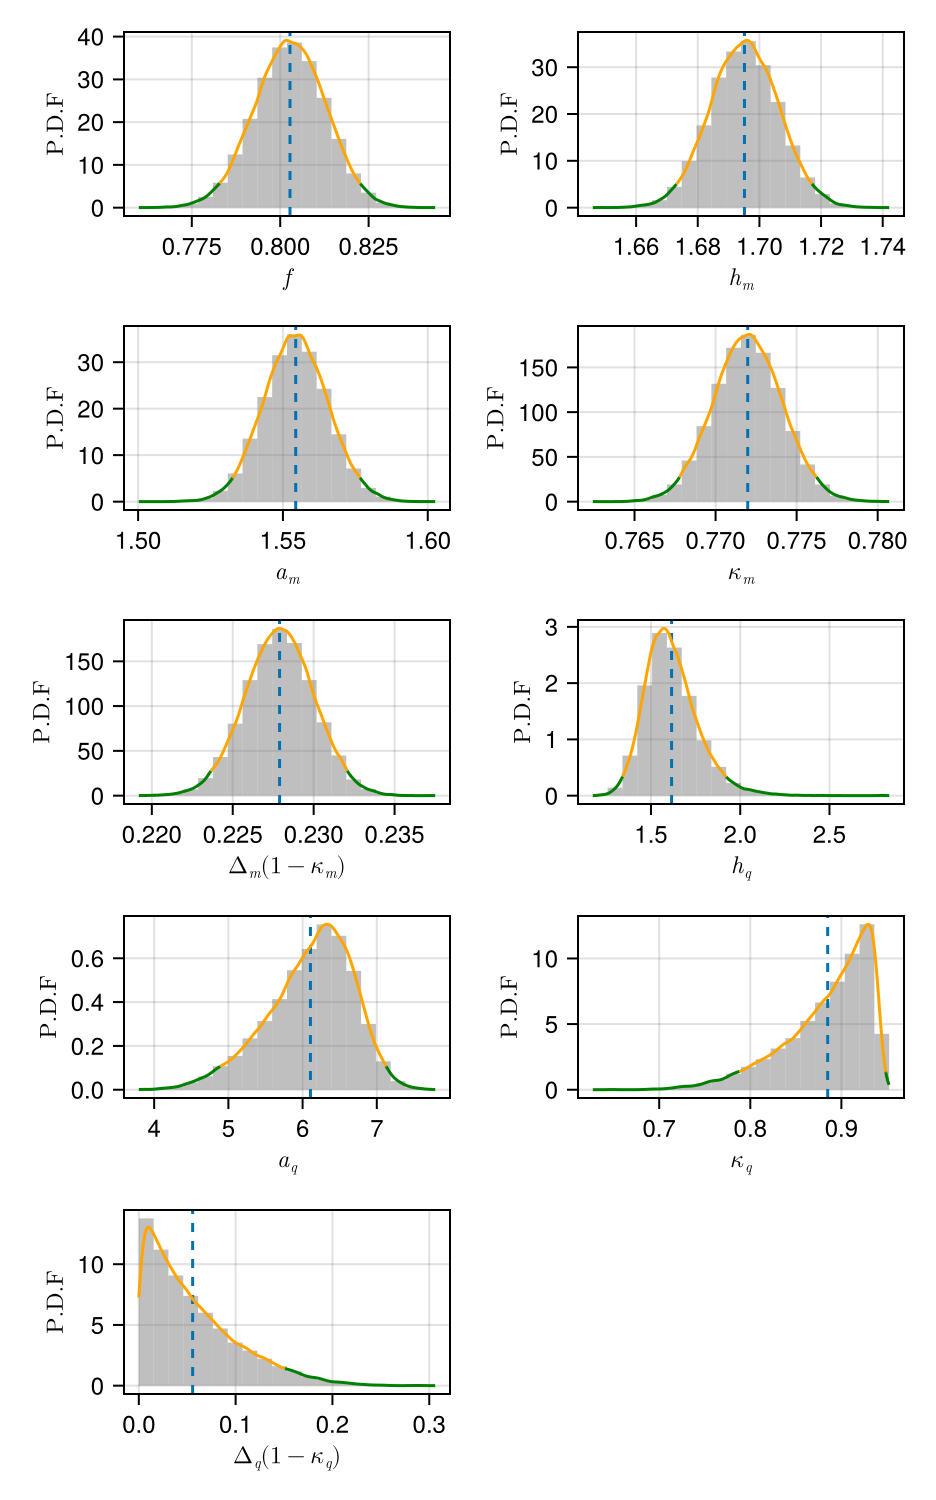

In [55]:
fig = Figure(size =  (468,750), fontsize = 12.)

κm_n = 4
Δm_n = 5

κq_n = 8
Δq_n = 9

ax_id = [(1,1),(1,2),(2,1),(2,2),(3,1),(3,2),(4,1),(4,2),(5,1)]

var_names = [L"f",L"h_m",L"a_m",L"\kappa_m",L"\Delta_m(1-\kappa_m)",L"h_q",L"a_q",L"\kappa_q",L"\Delta_q(1-\kappa_q)"]

prob_posterior = [1,4,5,8,9];
param_posterior = [2,3,6,7];

normalize_xaxis = false

κm_n = 4
Δm_n = 5

κq_n = 8
Δq_n = 9

all_ci = []

for (n,d) in enumerate(eachcol(all_posterior_m))

    if n == Δm_n
        d = d .* (1 .- all_posterior_m[:,κm_n])

    elseif n == Δq_n
        d = d .* (1 .- all_posterior_m[:,κq_n])
    else
        nothing
    end

    ax = Axis(fig[ax_id[n]...], xlabel = var_names[n],ylabel = L"\text{P.D.F}")
    hist!(ax,d,color = (:grey,0.5),bins = 20,normalization = :pdf)

    vlines!(mean(d),linestyle = :dash)

    k = kde(d)
    xgrid = range(minimum(d); stop = maximum(d), length = 1000)
    ygrid = pdf.(Ref(k), xgrid)

    threshold = first(hdr_thresholds([0.95], ygrid))

    # xgrid[findall(y -> y > threshold,ygrid)]

    push!(all_ci,xgrid[findall(y -> y > threshold,ygrid)])

    lines!(ax,xgrid,ygrid,color = [y < threshold ? :green : :orange for y in ygrid])

    if normalize_xaxis
        if n in prob_posterior
            xlims!(ax,0.,1.)
            hlines!(ax,1.)
        else
            xlims!(ax,0.,10.)
            hlines!(ax,0.1)
        end
    end

end

if save_figs
    save(plotsdir("InferenceFinal/PHill_Posteriors_Consolidated_"  * string(now()) * ".pdf"),fig)
end

fig